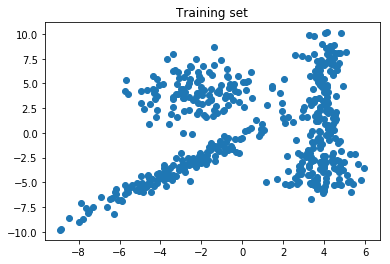

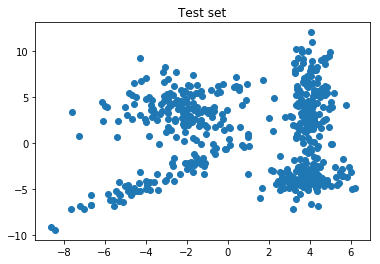

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train_file = "hwk3data/EMGaussian.train"
test_file = "hwk3data/EMGaussian.test"

def preprocess(lines):
    points = [line.strip().split(' ') for line in lines]
    return np.array(points, dtype=np.float)

with open(train_file) as f1, open(test_file) as f2:
    X_train = preprocess(f1.readlines())
    X_test = preprocess(f2.readlines())

plt.scatter(X_train[:, 0], X_train[:, 1])
plt.title("Training set")
plt.show()

plt.scatter(X_test[:, 0], X_test[:, 1])
plt.title("Test set")
plt.show()

In [2]:
from scipy.spatial.distance import cdist
from numpy.linalg import norm

class KMeans():
    def __init__(self, n_clusters=4, random_seed=0):
        self.random_seed = random_seed
        self.k = n_clusters
        
    def fit(self, X, threshold=1e-6):
        self.n, self.d = X.shape
        
        # Randomly initialize means
        np.random.seed = self.random_seed
        old_mu = self.mu = np.random.uniform(np.min(X), np.max(X), 
                                             size=(self.k, self.d))
        
        # Iterate until means stop moving
        self.mu = self._computeNewMu(X)
        while norm(self.mu - old_mu) > threshold:
            old_mu = self.mu
            self.mu = self._computeNewMu(X)
        
    def _computeNewMu(self, X):
         # E-step
        z_indices = np.argmin(cdist(X, self.mu), axis=1)
        self.z = np.zeros((self.n, self.k))
        self.z[np.arange(self.n), z_indices] = 1
        
        # M-step
        new_mu = self.z.T.dot(X) / self.z.T.sum(axis=1, keepdims=True)
        # If no points are assigned to a cluster we have a div by zero
        # This resets means which become nan to a random point
        new_mu[np.isnan(new_mu)] = np.random.uniform(np.min(X), np.max(X))
        return new_mu
    
    def computeNormalizedDistortion(self, X):
        z_indices = np.argmin(cdist(X, self.mu), axis=1)
        self.z = np.zeros((self.n, self.k))
        self.z[np.arange(self.n), z_indices] = 1
        return np.sum(cdist(X, self.mu) * self.z) / X.shape[0]
    
    def predict(self, X):
        z_indices = np.argmin(cdist(X, self.mu), axis=1)
        return z_indices
    
    # Used to get matrix of cluster assignments to initialize GMM
    def predictAssignmentMatrix(self, X):
        z_indices = np.argmin(cdist(X, self.mu), axis=1)
        z = np.zeros((self.n, self.k))
        z[np.arange(self.n), z_indices] = 1
        return z

Normalized distortion on training set = 2.20509172221
Normalized distortion on test set = 2.14197775249


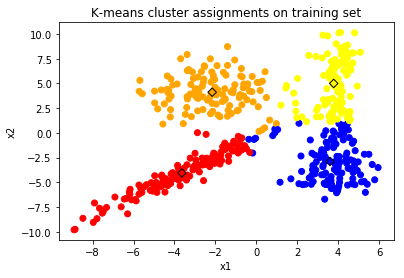

Normalized distortion on training set = 2.20784538499
Normalized distortion on test set = 2.1378854848


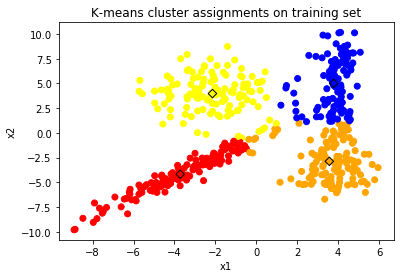

Normalized distortion on training set = 2.20784538499
Normalized distortion on test set = 2.1378854848


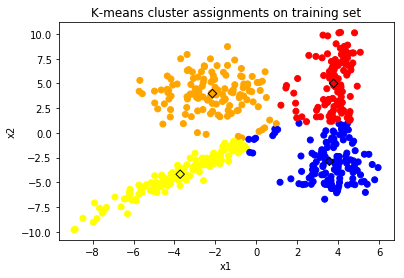

Normalized distortion on training set = 2.21883325643
Normalized distortion on test set = 2.17620906524


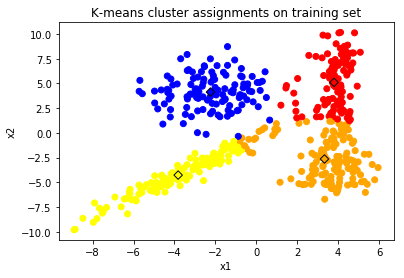

In [3]:
# For 4 different initializations
for i in xrange(4):
    
    # Train model
    model = KMeans(random_seed=i)
    model.fit(X_train)

    # Predict clusters
    cluster_predictions = model.predict(X_train)

    print "Normalized distortion on training set = {}".format(
        model.computeNormalizedDistortion(X_train))
    print "Normalized distortion on test set = {}".format(
        model.computeNormalizedDistortion(X_test))
    
    # Plot clusters and means
    color_map = {0: "blue", 1: "orange", 2: "red", 3: "yellow"}
    plt.scatter(X_train[:, 0], X_train[:, 1], 
                c=[color_map[cluster] for cluster in cluster_predictions])
    plt.scatter(model.mu[:, 0], model.mu[:, 1], marker="D", 
                c=[color_map[i] for i in xrange(4)], edgecolor="black")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("K-means cluster assignments on training set")
    plt.show()
    
# Keep track of matrix of cluster assignments to initialize GMM
z = model.predictAssignmentMatrix(X_train)

In [4]:
import math

""" GMM with cluster covariance matrices proportional to Identity """
class GaussianMixture():
    def __init__(self, w):
        self.n, self.k = w.shape
        # Initialize parameters
        self.w = w
    
    def fit(self, X, threshold=1e-6):
        self.d = X.shape[1]
        # Estimate parameters corresponding to initial cluster assignment
        self._MStep(X)
        # Keep track of log likelihood under model as we train
        log_likelihoods = [self._getNormalizedLogLikelihood(X)]
        self._EStep(X)
        self._MStep(X)
        log_like = self._getNormalizedLogLikelihood(X)
        while log_like - log_likelihoods[-1] > threshold:
            log_likelihoods.append(log_like)
            self._EStep(X)
            self._MStep(X)
            log_like = self._getNormalizedLogLikelihood(X)
        return log_likelihoods
        
    def _MStep(self, X):
        self.pi = np.sum(self.w, axis=0) / self.n
        self.mu = self.w.T.dot(X) / self.w.T.sum(axis=1, keepdims=True)
        self.sigma_squared = np.sum(cdist(X, self.mu) ** 2 * self.w, axis=0) \
                                / (np.sum(self.w, axis=0) * self.d)
        
    def _EStep(self, X):
        joint = self._getJoint(X)
        # Normalize to get conditional probabilities matrix
        # where we have p(x_i | z_i = j) at index i,j
        self.w = joint / np.sum(joint, axis=1, keepdims=True)
        
    # Returns a n*k matrix where we have p(x_i, z_i = j) at index i,j
    def _getJoint(self, X):
        inside_exp = - (cdist(X, self.mu) ** 2) / (2 * self.sigma_squared)
        norm_factor = (2 * math.pi * self.sigma_squared) ** (-self.d / 2.) 
        joint = self.pi * norm_factor * np.exp(inside_exp)
        return joint
    
    def _getNormalizedLogLikelihood(self, X):
        joint = self._getJoint(X)
        return np.sum(np.log(np.sum(joint, axis=1))) / X.shape[0]
        
    # Return the most likely latent variables for data points in X
    def predict(self, X):
        joint = self._getJoint(X)
        # Note : no need to normalize to take argmax
        return np.argmax(joint, axis=1)

Normalized log likelihood on training set = -5.2910528317
Normalized log likelihood on test set = -5.38749933452


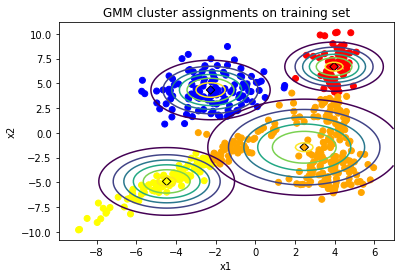

In [5]:
import matplotlib.mlab as mlab

# Initialize cluster assignment matrix with the one obtained by k-means
model = GaussianMixture(w=z)

# Train model
log_likelihoods = model.fit(X_train)
mu = model.mu
sigma = np.sqrt(model.sigma_squared)

# Predict clusters
cluster_predictions = model.predict(X_train)

print "Normalized log likelihood on training set = {}".format(
    model._getNormalizedLogLikelihood(X_train))
print "Normalized log likelihood on test set = {}".format(
    model._getNormalizedLogLikelihood(X_test))

# Plot cluster assignments and means
plt.scatter(X_train[:, 0], X_train[:, 1], 
            c=[color_map[cluster] for cluster in cluster_predictions])
plt.scatter(model.mu[:, 0], model.mu[:, 1], marker="D", 
                c=[color_map[i] for i in xrange(4)], edgecolor="black")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("GMM cluster assignments on training set")
    
# Print covariance contour plots
x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
X1, X2 = np.meshgrid(np.linspace(x1_min, x1_max, 100), 
                     np.linspace(x2_min, x2_max, 100))
for j in xrange(4):
    Z = mlab.bivariate_normal(X1, X2, sigma[j], sigma[j],
                              mu[j, 0], mu[j, 1], 0.)
    plt.contour(X1, X2, Z)
plt.show()

In [6]:
from numpy.linalg import det, inv

""" GMM with general cluster covariance matrices """
class GaussianMixtureGeneral():
    def __init__(self, w):
        self.n, self.k = w.shape
        # Initialize parameters
        self.w = w
    
    def fit(self, X, threshold=1e-2):
        self.d = X.shape[1]
        # Estimate parameters corresponding to initial cluster assignment
        self._MStep(X)
        # Keep track of log likelihood under model as we train
        log_likelihoods = [self._getNormalizedLogLikelihood(X)]
        self._EStep(X)
        self._MStep(X)
        log_like = self._getNormalizedLogLikelihood(X)
        while log_like - log_likelihoods[-1] > threshold:
            log_likelihoods.append(log_like)
            self._EStep(X)
            self._MStep(X)
            log_like = self._getNormalizedLogLikelihood(X)
        return log_likelihoods
        
    def _MStep(self, X):
        self.pi = np.sum(self.w, axis=0) / self.n
        self.mu = self.w.T.dot(X) / self.w.T.sum(axis=1, keepdims=True)
        # Compute the covariance matrix for each cluster in turn
        # sigma has shape (k, d, d)
        self.sigma = []
        for j in xrange(self.k):
            dist = X - self.mu[j]
            sigma_j = dist.T.dot(dist * self.w[:, j].reshape(-1, 1))
            sigma_j = sigma_j / np.sum(self.w[:, j])
            self.sigma.append(sigma_j)
        self.sigma = np.array(self.sigma)
        # Might be useful to avoid nan in the case all weights 
        # for a cluster are 0 (shouldn't happen)
        self.sigma[np.isnan(self.sigma)] = 25
            
    def _EStep(self, X):
        joint = self._getJoint(X)
        # Normalize to get conditional probabilities matrix
        # where we have p(x_i | z_i = j) at index i,j
        self.w = joint / np.sum(joint, axis=1, keepdims=True)
        
    # Returns a n*k matrix where we have p(x_i, z_i = j) at index i,j
    def _getJoint(self, X):
        joint = []
        for j in xrange(self.k):
            mu = self.mu[j]
            inv_sigma = inv(self.sigma[j])
            dist = X - mu
            inside_exp = -np.diag(dist.dot(inv_sigma).dot(dist.T)) / 2
            norm_factor = (2 * math.pi) ** (-self.d / 2.) * \
                math.sqrt(det(inv_sigma))
            joint.append(self.pi[j] * norm_factor * np.exp(inside_exp))
        joint = np.array(joint).T
        return joint
    
    def _getNormalizedLogLikelihood(self, X):
        joint = self._getJoint(X)
        return np.sum(np.log(np.sum(joint, axis=1))) / X.shape[0]
    
    def _getLogLikelihood(self, X):
        joint = self._getJoint(X)
        return np.sum(np.log(np.sum(joint, axis=1)))
        
    # Return the most likely latent variables for data points in X
    def predict(self, X):
        joint = self._getJoint(X)
        # Note : no need to normalize to take argmax
        return np.argmax(joint, axis=1)

Normalized log likelihood on training set = -4.66504420691
Normalized log likelihood on test set = -4.84802722782
Log likelihood on training set = -2332.52210346
Log likelihood on test set = -2424.01361391


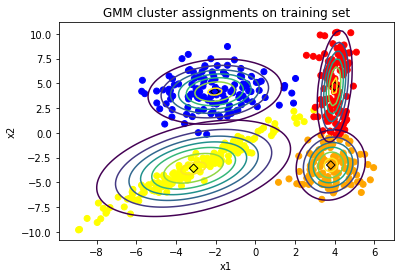

In [7]:
# Initialize cluster assignment matrix with the one obtained by k-means
model = GaussianMixtureGeneral(w=z)

# Train model
log_likelihoods = model.fit(X_train)
mu = model.mu
sigma = np.sqrt(model.sigma)

# Predict clusters
cluster_predictions = model.predict(X_train)

print "Normalized log likelihood on training set = {}".format(
    model._getNormalizedLogLikelihood(X_train))
print "Normalized log likelihood on test set = {}".format(
    model._getNormalizedLogLikelihood(X_test))
print "Log likelihood on training set = {}".format(
    model._getLogLikelihood(X_train))
print "Log likelihood on test set = {}".format(
    model._getLogLikelihood(X_test))

# Plot clusters and means
plt.scatter(X_train[:, 0], X_train[:, 1], 
            c=[color_map[cluster] for cluster in cluster_predictions])
plt.scatter(model.mu[:, 0], model.mu[:, 1], marker="D", 
                c=[color_map[i] for i in xrange(4)], edgecolor="black")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("GMM cluster assignments on training set")

# Print covariance contour plots
x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
X1, X2 = np.meshgrid(np.linspace(x1_min, x1_max, 100), 
                     np.linspace(x2_min, x2_max, 100))
for j in xrange(4):
    Z = mlab.bivariate_normal(X1, X2, sigma[j, 0, 0], sigma[j, 1, 1],
                              mu[j, 0], mu[j, 1], sigma[j, 0, 1])
    plt.contour(X1, X2, Z)
plt.show()